In [1]:
# imports
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from path import Path

In [2]:
import src.visualizer as vis
import src.data.monelnet40 as modelnet40

root = "./src/data/modelnet40_ply_hdf5_2048"
dataset = modelnet40.ModelNet40(root="./src/data/modelnet40_hdf5_2048")
# get dataloader
BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
# iterate over the dataset
for i_batch, batched_data in enumerate(dataloader):
    data = batched_data["data"]
    label = batched_data["label"]
    print(f"Batch {i_batch} data size: {data.size()}")
    print(f"Batch {i_batch} label size: {label.size()}")
    break

# vis(dataset.data, dataset.labels, dataset.classes, 0)

Batch 0 data size: torch.Size([32, 2048, 3])
Batch 0 label size: torch.Size([32, 1])


In [3]:
vis.visualize_point_cloud(dataset.data, dataset.labels[0], dataset.classes, 0)

torch.Size([9843, 1])


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_4760\1599198023.py:12: UserWarning:

cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_4760\1599198023.py:13: UserWarning:

cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_4760\1599198023.py:14: UserWarning:

cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)



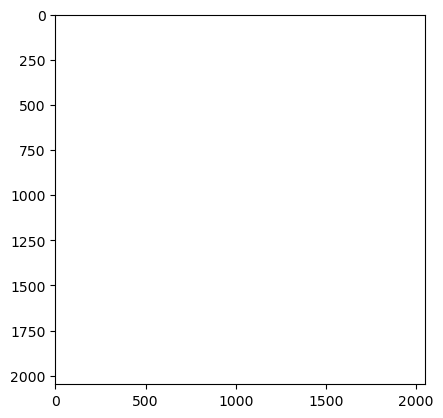

In [46]:
# create a DBSCAN + K-means hybrid
# that clusters based on continuity and compactness
# DBSCAN for continuity

# K-means for compactness (we want patches with different geometries) (so we need the geometric feature variance to be high!)
# so we will cluster and then penalize non_compact clusters and non_continous clusters and
# do a covariance matrix for the points of x
# cov = torch.cov(x)
# actualy do covariance for the rows not the columns
# this means that the final cov matrix will be of shape 2048x2048 (the number of points in the point cloud) and not 3x3 (the number of features)

cov_x = torch.cov(x[:, 0].unsqueeze(1))
cov_y = torch.cov(x[:, 1].unsqueeze(1))
cov_z = torch.cov(x[:, 2].unsqueeze(1))

cov = torch.sqrt(cov_x**2 + cov_y**2 + cov_z**2)
# plot
plt.imshow(cov)

torch.Size([24, 3])


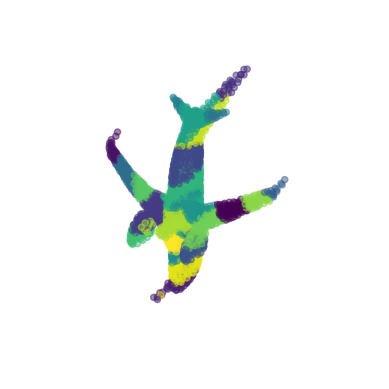

In [82]:
# farthest_point_sampling

import numpy as np


def farthest_point_sampling(arr, n_sample, start_idx=None):
    n_points, n_dim = arr.shape

    if (start_idx is None) or (start_idx < 0):
        start_idx = np.random.randint(0, n_points)

    sampled_indices = [start_idx]
    min_distances = np.full(n_points, np.inf)

    for _ in range(n_sample - 1):
        current_point = arr[sampled_indices[-1]]
        dist_to_current_point = np.linalg.norm(arr - current_point, axis=1)
        min_distances = np.minimum(min_distances, dist_to_current_point)
        farthest_point_idx = np.argmax(min_distances)
        sampled_indices.append(farthest_point_idx)

    return np.array(sampled_indices)


k = 24
point_idx = farthest_point_sampling(x.numpy(), k)
# point_idx = torch.tensor(point_idx)
clusters = x[point_idx]
print(clusters.shape)
# plot x and point_idx
E = torch.cdist(x, clusters)
F, z = torch.min(E, dim=1)
# 3d plot with labels = z
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.patch.set_alpha(0.2)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=z, alpha=0.5)
# make axis equal
ax.set_box_aspect([1, 1, 1])
# make axis not visible
ax.axis("off")
# make background alpha 0
# save image
plt.savefig("farthest_point_sampling.png")
plt.show()

In [6]:
x

tensor([[ 0.0066, -0.0138, -0.9249],
        [-0.0090, -0.0357, -0.9135],
        [ 0.0020,  0.0097, -0.9086],
        ...,
        [-0.1584,  0.0689,  0.8284],
        [-0.2308,  0.0796,  0.8284],
        [-0.0763,  0.0612,  0.8303]])

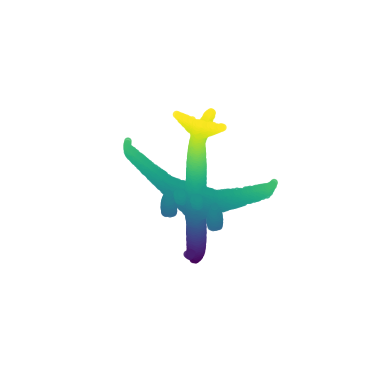

NameError: name 'cov_m' is not defined

In [85]:
import matplotlib.pyplot as plt

num = 30
# argsort x based on 3rd dim

x = dataset.data[num]
# sort x based on [:, -1]
x = x[x[:, -1].argsort()][:2000]
# plot as 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    x[:, 0], x[:, 1], x[:, 2], marker="o", c=x[:, 2], cmap="viridis", alpha=0.8, s=20
)
plt.axis("off")
plt.axis("equal")
plt.show()
plt.imshow(cov_m, cmap="viridis", interpolation="nearest")
# make axis not visible and equal
plt.axis("off")
plt.axis("equal")
plt.show()
# also show variances
# variance of x
var_x = torch.var(x[:, 0])
var_y = torch.var(x[:, 1])
var_z = torch.var(x[:, 2])

In [ ]:
pointcloud = PointSampler(2048)((verts, faces))

In [ ]:
pointcloud.shape

In [ ]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return norm_pointcloud

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        theta = random.random() * 2.0 * math.pi
        rot_matrix = np.array(
            [
                [math.cos(theta), -math.sin(theta), 0],
                [math.sin(theta), math.cos(theta), 0],
                [0, 0, 1],
            ]
        )

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud


class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

In [ ]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [ ]:
pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        return torch.from_numpy(pointcloud)

In [ ]:
ToTensor()(noisy_rot_pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024), Normalize(), ToTensor()])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
class PointCloudData(Dataset):
    def __init__(
        self, root_dir, valid=False, folder="train", transform=default_transforms()
    ):
        self.root_dir = root_dir
        folders = [
            dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir / dir)
        ]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir / Path(category) / folder
            for file in os.listdir(new_dir):
                if file.endswith(".off"):
                    sample = {}
                    sample["pcd_path"] = new_dir / file
                    sample["category"] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]["pcd_path"]
        category = self.files[idx]["category"]
        with open(pcd_path, "r") as f:
            pointcloud = self.__preproc__(f)
        return {"pointcloud": pointcloud, "category": self.classes[category]}

Transforms for training. 1024 points per cloud as in the paper!

In [ ]:
train_transforms = transforms.Compose(
    [PointSampler(1024), Normalize(), RandRotation_z(), RandomNoise(), ToTensor()]
)

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder="test", transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
inv_classes

In [ ]:
print("Train dataset size: ", len(train_ds))
print("Valid dataset size: ", len(valid_ds))
print("Number of classes: ", len(train_ds.classes))
print("Sample pointcloud shape: ", train_ds[0]["pointcloud"].size())
print("Class: ", inv_classes[train_ds[0]["category"]])

In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        # initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if xb.is_cuda:
            init = init.cuda()
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64


class PointNet(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1)
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
    return criterion(outputs, labels) + alpha * (
        torch.norm(diff3x3) + torch.norm(diff64x64)
    ) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
pointnet = PointNet()
pointnet.to(device)

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None, epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data["pointcloud"].to(device).float(), data["category"].to(
                device
            )
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1, 2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:  # print every 10 mini-batches
                print(
                    "[Epoch: %d, Batch: %4d / %4d], loss: %.3f"
                    % (epoch + 1, i + 1, len(train_loader), running_loss / 10)
                )
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data["pointcloud"].to(device).float(), data[
                        "category"
                    ].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1, 2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100.0 * correct / total
            print("Valid accuracy: %d %%" % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_" + str(epoch) + ".pth")

In [ ]:
train(pointnet, train_loader, valid_loader, save=False)

## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load("save.pth"))
pointnet.eval()

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print("Batch [%4d / %4d]" % (i + 1, len(valid_loader)))

        inputs, labels = data["pointcloud"].float(), data["category"]
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
cm

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

In [ ]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [24]:
import torch

import pytorch3d
from pytorch3d.ops import sample_points_from_meshes
import numpy as np

# load meshes
from pytorch3d.io import load_objs_as_meshes

# i have off files and i wanna sample points from them. first lets read them
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes

path = "./src/data/ModelNet40/airplane/train/airplane_0001.off"
verts, faces, aux = load_obj(path)
print(verts.shape)
print(faces.verts_idx.shape)
# # create a Meshes object
# mesh = Meshes(verts=[verts], faces=[faces.verts_idx])
# # sample points
# n_points = 1024
# points = sample_points_from_meshes(mesh, n_points)

# # visualise
# from pytorch3d.vis.plotly_vis import plot_scene
# import plotly.graph_objs as go

# fig = plot_scene(
#     {
#         "points": [points],
#         "meshes": [mesh],
#     }
# )
# fig.show()

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "c:\Users\panagiotis.rigas\.conda\envs\Pytorch_main\Lib\site-packages\iopath\common\file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "c:\Users\panagiotis.rigas\.conda\envs\Pytorch_main\Lib\site-packages\iopath\common\event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'


torch.Size([0, 3])
torch.Size([0, 3])


c:\Users\panagiotis.rigas\.conda\envs\Pytorch_main\Lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [25]:
# path = "src\data\ModelNet40\airplane\train\airplane_0001.off"
path = "./src/data/ModelNet40/airplane/train/airplane_0001.off"

In [34]:
# read off file
def read_off(file):
    if "OFF" != file.readline().strip():
        raise ("Not a valid OFF header")
    n_verts, n_faces, _ = list(map(int, file.readline().strip().split(" ")))
    verts = [
        [float(x) for x in file.readline().strip().split(" ")] for _ in range(n_verts)
    ]
    faces = [
        [int(x) for x in file.readline().strip().split(" ")][1:] for _ in range(n_faces)
    ]
    return verts, faces


# read off file
with open(path, "r") as f:
    verts, faces = read_off(f)
    # verts = np.array(verts)
    # faces = np.array(faces)
    verts = torch.tensor(verts)
    faces = torch.tensor(faces)
    print(verts.shape)
    print(faces.shape)
    # verts = verts.unsqueeze(0)
    # faces = faces.unsqueeze(0)
mesh = Meshes(verts=[verts], faces=[faces])

# create a Meshes object

torch.Size([90714, 3])
torch.Size([104773, 3])


(-152.26486053466797,
 227.71481170654297,
 -254.55207214355468,
 60.23920593261719)

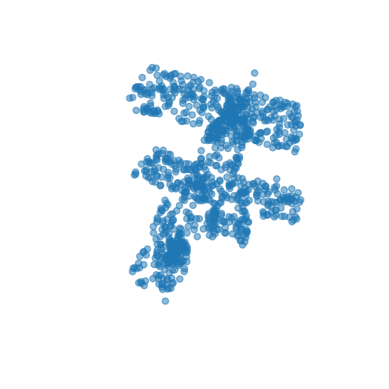

In [61]:
# lets sample it
n_points = 1024
points = sample_points_from_meshes(mesh, n_points)
# plot point cloud
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.patch.set_alpha(0.2)
ax.scatter(points[0, :, 0], points[0, :, 1], points[0, :, 2], alpha=0.5)
# make axis equal
ax.set_box_aspect([1, 1, 1])
# make axis not visible
ax.axis("off")